# Overview

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,LSTM,BatchNormalization,Conv1D,MaxPooling1D
from keras.layers import LSTM, Dropout, Dense, Activation

# Google

In [112]:
data = pd.read_csv('Google.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659000
1,2004-08-20,50.555557,54.594593,50.300301,54.209209,54.209209,22834300
2,2004-08-23,55.430431,56.796795,54.579578,54.754753,54.754753,18256100
3,2004-08-24,55.675674,55.855854,51.836838,52.487488,52.487488,15247300
4,2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188600


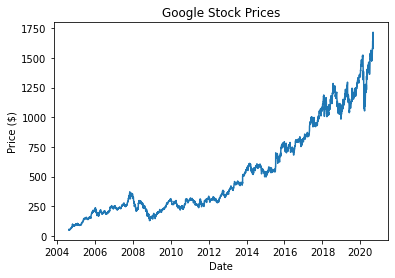

In [113]:
data['Date'] = pd.to_datetime(data['Date'],format='%Y/%m/%d')

plt.plot(data['Date'], data['Close'])
plt.title('Google Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.show()

In [114]:
#how many days data will be used to create series to train RNN
seq_len = 30
nr_days =7

def scale_data(data):
    for column in data.columns:
        data[column] = preprocessing.scale(data[column].values)
    return data

In [115]:
import numpy as np
from sklearn import preprocessing


def process_data(data):
    '''This function was adapted from Sarkar S. (2019) '''
    
    data["future_price"]= data["Close"].shift(-nr_days) # Shift it by 7 days

    ## dropping NA values
    data.dropna(inplace=True)

    data["Label"]=np.where(data["future_price"]>=data["Close"],1,0)

    ## Dropping the date colum since we won't be able to rescale it
    data = data.drop('Date', 1)
    data.drop('future_price',1,inplace=True)
    
    sequence=[]
    # We want to scale the data except the label part since it is already 0 and 1
    temp=data.loc[:, data.columns != 'Label']
    temp=scale_data(temp)
    # print(f"temp{temp[:30]}")
    for i in range (len(temp)-seq_len):
        sequence.append([np.array(temp[i:i+seq_len]),data.iloc[i+seq_len,-1]]) # iloc part is to take last column data i.e. labels

    np.random.shuffle(sequence)

    #Now we will count the sells and buys to find optimal investments
    buy=[]
    sell=[]
    for seq ,label in sequence:
        if label == 0:
            sell.append([seq,label])
        else:
            buy.append([seq,label])
            
            
    buys=len(buy)
    sells=len(sell)
    print(f"Buys:{buys} Sells:{sells}")

    X=[]
    y=[]
    for seq ,label in sequence:
        X.append(seq)
        y.append(label)

    return np.array(X),np.array(y)

In [116]:
#from sklearn import preprocessing
import warnings
warnings.filterwarnings("ignore")

process_data(data)
data.head()

Buys:2321 Sells:1683


,Date,Open,High,Low,Close,Adj Close,Volume,future_price,Label
0,2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659000,51.056057,1
1,2004-08-20,50.555557,54.594593,50.300301,54.209209,54.209209,22834300,51.236237,0
2,2004-08-23,55.430431,56.796795,54.579578,54.754753,54.754753,18256100,50.175175,0
3,2004-08-24,55.675674,55.855854,51.836838,52.487488,52.487488,15247300,50.805805,0
4,2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188600,50.055054,0


In [117]:
data['Label'].value_counts()

1    2345
0    1689
Name: Label, dtype: int64

# Modeling

In [118]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,LSTM,BatchNormalization,Conv1D,MaxPooling1D
import matplotlib.pyplot as plt
from sklearn import preprocessing
import pandas as pd

In [119]:
training_size=0.8

spilt_point=int(training_size*len(df))

#splitting data for training and testing in ratio 80:20
train_data = data[:spilt_point]
test_data = data[spilt_point:]

train_x,train_y=process_data(train_data)

test_x,test_y=process_data(test_data)


Buys:1823 Sells:1356
Buys:472 Sells:309


In [120]:
## building the network

model=Sequential()
model.add(LSTM(256,input_shape=(train_x.shape[1:]),return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(LSTM(256,return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(LSTM(256,return_sequences=False))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(32,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))


model.compile(loss='binary_crossentropy',optimizer="adam",metrics=['accuracy'])

In [122]:
history=model.fit(train_x,train_y,batch_size=30,epochs=5,validation_data=(test_x,test_y))

score=model.evaluate(test_x,test_y)
print("Validation accuracy",score[1]*100)
print("Validation loss",score[0]*100)

Train on 3179 samples, validate on 781 samples
Epoch 1/5
3179/3179 [==============================] - 51s 16ms/sample - loss: 0.7034 - acc: 0.5388 - val_loss: 0.6706 - val_acc: 0.5992
Epoch 2/5
3179/3179 [==============================] - 52s 16ms/sample - loss: 0.6963 - acc: 0.5480 - val_loss: 0.6851 - val_acc: 0.6044
Epoch 3/5
3179/3179 [==============================] - 53s 17ms/sample - loss: 0.6911 - acc: 0.5584 - val_loss: 0.6904 - val_acc: 0.5109
Epoch 4/5
3179/3179 [==============================] - 55s 17ms/sample - loss: 0.6952 - acc: 0.5376 - val_loss: 0.6847 - val_acc: 0.5736
Epoch 5/5
781/781 [==============================] - 4s 4ms/sample - loss: 0.6755 - acc: 0.5480
Validation accuracy 54.80153560638428
Validation loss 67.55420528209164


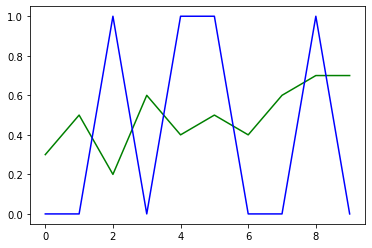

In [53]:
prediction=model.predict(test_x)

plt.plot(prediction[30:50],color='green',label='predicted_data')
plt.plot(test_y[30:50],color='blue',label='actual_data')

plt.show()


In [123]:
from sklearn.metrics import roc_curve, classification_report, accuracy_score, auc
prediction=model.predict(test_x)

y_pred = []

for i in prediction:
    if i >0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

print(classification_report(test_y, y_pred))

              precision    recall  f1-score   support

           0       0.39      0.24      0.30       309
           1       0.60      0.75      0.67       472

    accuracy                           0.55       781
   macro avg       0.49      0.50      0.48       781
weighted avg       0.52      0.55      0.52       781



In [124]:
# plot ROC curve
def ROCplot(y_test,y_score):
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    roc_auc = auc(fpr,tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

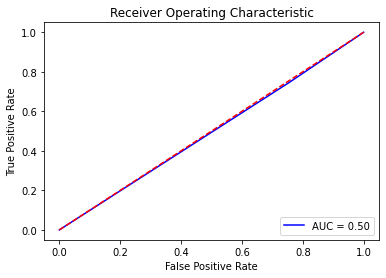

In [125]:
ROCplot(test_y, y_pred)

# Amazon

In [126]:
amazon_data = pd.read_csv('Amazon.csv')
amazon_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200


In [138]:
amazon_data.shape

(5845, 9)

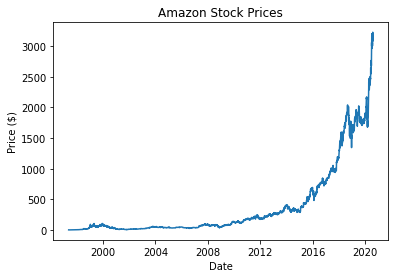

In [127]:
amazon_data['Date'] = pd.to_datetime(amazon_data['Date'],format='%Y/%m/%d')

plt.plot(amazon_data['Date'], amazon_data['Close'])
plt.title('Amazon Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.show()

In [128]:
process_data(amazon_data)
amazon_data.head()

Buys:3219 Sells:2596


,Date,Open,High,Low,Close,Adj Close,Volume,future_price,Label
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000,1.583333,0
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000,1.531250,0
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800,1.505208,0
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200,1.500000,0
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200,1.510417,1


In [129]:
training_size=0.8

spilt_point=int(training_size*len(df))

#splitting data for training and testing in ratio 80:20
train_data = amazon_data[:spilt_point]
test_data = amazon_data[spilt_point:]

train_x,train_y=process_data(train_data)

test_x,test_y=process_data(test_data)

Buys:1675 Sells:1504
Buys:1507 Sells:1085


In [130]:
## building the network

model=Sequential()
model.add(LSTM(256,input_shape=(train_x.shape[1:]),return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(LSTM(256,return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(LSTM(256,return_sequences=False))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(32,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))


model.compile(loss='binary_crossentropy',optimizer="adam",metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 30, 256)           269312    
_________________________________________________________________
dropout_16 (Dropout)         (None, 30, 256)           0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 30, 256)           1024      
_________________________________________________________________
lstm_13 (LSTM)               (None, 30, 256)           525312    
_________________________________________________________________
dropout_17 (Dropout)         (None, 30, 256)           0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 30, 256)           1024      
_________________________________________________________________
lstm_14 (LSTM)               (None, 256)              

In [131]:
history=model.fit(train_x,train_y,batch_size=30,epochs=5,validation_data=(test_x,test_y))

score=model.evaluate(test_x,test_y)
print("Validation accuracy",score[1])
print("Validation loss",score[0])

Train on 3179 samples, validate on 2592 samples
Epoch 1/5
3179/3179 [==============================] - 69s 22ms/sample - loss: 0.7861 - acc: 0.5074 - val_loss: 0.6848 - val_acc: 0.5687
Epoch 2/5
3179/3179 [==============================] - 67s 21ms/sample - loss: 0.7234 - acc: 0.5366 - val_loss: 0.6945 - val_acc: 0.5073
Epoch 3/5
3179/3179 [==============================] - 68s 22ms/sample - loss: 0.7198 - acc: 0.5282 - val_loss: 0.6829 - val_acc: 0.5814
Epoch 4/5
3179/3179 [==============================] - 67s 21ms/sample - loss: 0.7056 - acc: 0.5404 - val_loss: 0.6862 - val_acc: 0.5814
Epoch 5/5
2592/2592 [==============================] - 13s 5ms/sample - loss: 0.6959 - acc: 0.5019
Validation accuracy 0.501929
Validation loss 0.6959323515126734


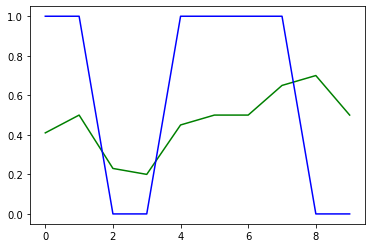

In [82]:
prediction=model.predict(test_x)

plt.plot(prediction,color='green',label='predicted_data')
plt.plot(test_y[40:50],color='blue',label='actual_data')

plt.show()

In [132]:
from sklearn.metrics import roc_curve, classification_report, accuracy_score, auc
prediction=model.predict(test_x)

y_pred = []

for i in prediction:
    if i >0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

print(classification_report(test_y, y_pred))

              precision    recall  f1-score   support

           0       0.40      0.36      0.38      1085
           1       0.57      0.60      0.58      1507

    accuracy                           0.50      2592
   macro avg       0.48      0.48      0.48      2592
weighted avg       0.50      0.50      0.50      2592



In [133]:
# plot ROC curve
def ROCplot(y_test,y_score):
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    roc_auc = auc(fpr,tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

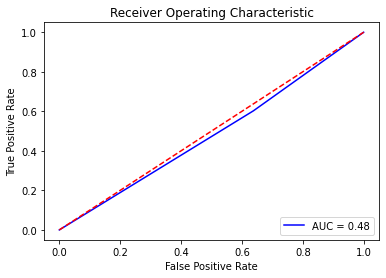

In [134]:
ROCplot(test_y, y_pred)